In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as lin
import scipy.sparse.linalg as slin
import itertools
import sklearn
from IPython.display import display_markdown, Markdown
%matplotlib inline

# read data

## read Reguly 06 data

In [2]:
pd.read_csv('data/yeast/reguly06/LC_BIOCHEMICAL_011906_MinusRNA.txt',sep='\t', nrows = 1)


,Bait gene/protein,Hit gene/protein,Bait Standard Name,Hit Standard Name,Experimental System,Source,PubMed ID
0,YBR236C,YML010W,ABD1,SPT5,Affinity Capture-MS,Lindstrom DL et al,12556496


In [2]:
usecols = 'Bait gene/protein,Hit gene/protein'.split(',')
colnames = 'bait,hit'.split(',')
reguly = pd.read_csv('data/yeast/reguly06/LC_BIOCHEMICAL_011906_MinusRNA.txt',sep='\t', usecols = usecols,
                     dtype="str")
reguly = reguly.rename(columns={k : v for k,v in zip(usecols,colnames)})
display(reguly)
print(np.count_nonzero(reguly.duplicated()), 'duplicates')
print(len(reguly) - np.count_nonzero(reguly.duplicated()), 'unique')

,bait,hit
0,YBR236C,YML010W
1,YML010W,YBR236C
2,YDR448W,YPL254W
3,YDR448W,YDR176W
4,YDR448W,YOR257W
...,...,...
21130,YKL138C-A,YDR201W
21131,YKL138C-A,YKR083C
21132,YKL138C-A,YDR016C
21133,YKL138C-A,YBR233W-A


6966 duplicates
14169 unique


In [3]:
# sort each (bait, hit) row since we are only interested in undirected edges
# this will cause transposes to look like duplicates, which then get removed
pint = pd.DataFrame(np.sort(reguly,axis=1),columns=['a','b'])
display(pint)
duplicated = pint.duplicated()
print(np.count_nonzero(duplicated), 'duplicates')
pint = pint[~duplicated]
print(len(pint), 'unique')

,a,b
0,YBR236C,YML010W
1,YBR236C,YML010W
2,YDR448W,YPL254W
3,YDR176W,YDR448W
4,YDR448W,YOR257W
...,...,...
21130,YDR201W,YKL138C-A
21131,YKL138C-A,YKR083C
21132,YDR016C,YKL138C-A
21133,YBR233W-A,YKL138C-A


9277 duplicates
11858 unique


In [4]:
gene_names = list(set(pint['a'].append(pint['b']))) #find unique gene names
gene_names.sort()
n_genes = len(gene_names)
print(n_genes,'genes')
gene_name_hash = {k : v for k,v in zip(gene_names,range(len(gene_names)))}

3307 genes


In [198]:
#look for mitochondrial genes?
gene_series = pd.Series(gene_names)
gene_series[gene_series.str.match(r'Q.*')]

0     Q0045
1     Q0080
2     Q0085
3     Q0105
4     Q0115
5     Q0120
6     Q0130
7     Q0140
8     Q0160
9     Q0250
10    Q0275
dtype: object

In [5]:
import scipy.sparse as sparse
ai = pint.loc[:,'a'].apply(lambda x: gene_name_hash[x])
bi = pint.loc[:,'b'].apply(lambda x: gene_name_hash[x])
#define upper triangle of protein interaction matrix
pi_ut_coo = sparse.coo_matrix((np.ones(len(pint)),(ai,bi)),shape = (n_genes,n_genes))
#convert to csc for efficiency and flexibility
pi_csc = sparse.csc_matrix(pi_ut_coo,dtype=np.int)
#symmetrize csc matrix
rows, cols = pi_csc.nonzero()
pi_csc[cols, rows] = pi_csc[rows, cols]

/home/akuczala/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


According to Paladugu, there are 3289 proteins and 11334 interactions (excluding mitochrondrial genes)

In [6]:
print(n_genes,"genes",len(ai),"interactions")

3307 genes 11858 interactions


### visualization

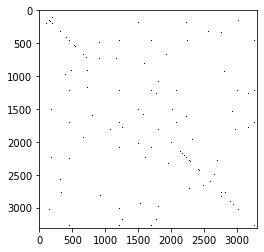

In [44]:
pi_dense = pi_csc.toarray()
plt.imshow(pi_dense,cmap='gray_r')

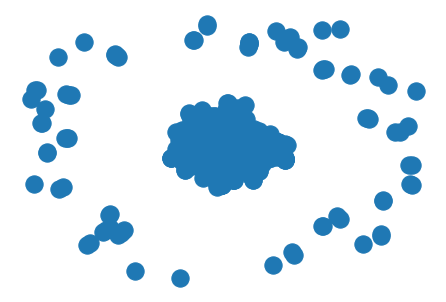

In [51]:
import networkx as nx
pi_graph = nx.from_scipy_sparse_matrix(pi_csc)
nx.draw(pi_graph)

In [49]:
np.count_nonzero(np.diag(pi_dense))

524

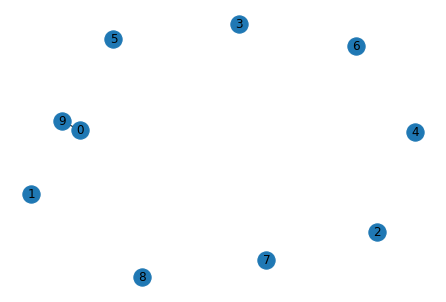

In [17]:
cluster_model.cluster_centers_

<0x3307 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

## read Costanzo 10 or 16 data

In [52]:
pd.read_csv('data/yeast/costanzo10.txt',sep='\t', nrows = 1)

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,Pubmed ID,Organism Interactor A,Organism Interactor B,Throughput,Score,Modification,Phenotypes,Qualifications,Tags,Source Database
0,354378,851236,850395,31767,31012,YAL063C,YCR028C-A,FLO9,RIM1,flocculin FLO9|L000003331,...,20093466,559292,559292,High Throughput,-0.1969,-,colony size,A Synthetic Genetic Array (SGA) analysis was c...,-,BIOGRID


In [7]:
usecols = 'Systematic Name Interactor A,Systematic Name Interactor B,Score'.split(',')
names = {k : v for k,v in zip(usecols,'a,b,score'.split(','))}

costanzo = pd.read_csv('data/yeast/costanzo16.tab2',
                 sep='\t', usecols = usecols,
                 dtype = {k : v for k,v in zip(usecols,[np.str,np.str,np.float])},
                na_values = ['-'])
costanzo = costanzo.rename(columns = names)
costanzo

,a,b,score
0,YAL001C,YDL126C,0.1745
1,YAL001C,YDL145C,0.1957
2,YAL001C,YDR238C,0.2682
3,YAL001C,YDR280W,0.2291
4,YAL001C,YDR292C,0.1834
...,...,...,...
326785,YPR201W,YOR140W,-0.1497
326786,YPR201W,YOR270C,-0.1228
326787,YPR201W,YPL101W,-0.1839
326788,YPR201W,YPL106C,-0.1640


In [8]:
duplicated = costanzo.drop('score',axis=1).duplicated()
print(np.count_nonzero(duplicated), 'duplicates')
costanzo_unique = costanzo[~duplicated]
print(len(costanzo_unique),'unique')

1156 duplicates
325634 unique


In [204]:
#attempt to find mitochondrial genes?
costanzo_unique[costanzo_unique.a.str.match(r't.*')]

,a,b,score


## assign indices to gene interaction network

In [9]:
def hashbrown(name):
    try:
        return gene_name_hash[name]
    except:
        return -1

Build gene interaction dataframe `gint`

In [10]:
gint = costanzo_unique[['a','b']].applymap(hashbrown)
gint.columns = [gint.columns,['i','i']]
gint['a','name'] = costanzo_unique['a']
gint['b','name'] = costanzo_unique['b']
gint['score'] = costanzo_unique['score']
gint = gint[np.logical_and(gint.a.i > -1,gint.b.i > -1) ]
display(gint)

gi_coo = sparse.coo_matrix((gint['score'],(gint.a.i,gint.b.i)))
gi_csc = sparse.csc_matrix(gi_coo)

assert(gi_csc.shape == pi_csc.shape)

,a,b,a,b,score
,i,i,name,name,
0,11,445,YAL001C,YDL126C,0.1745
1,11,459,YAL001C,YDL145C,0.1957
2,11,653,YAL001C,YDR238C,0.2682
3,11,669,YAL001C,YDR280W,0.2291
4,11,674,YAL001C,YDR292C,0.1834
...,...,...,...,...,...
326785,3306,2922,YPR201W,YOR140W,-0.1497
326786,3306,2995,YPR201W,YOR270C,-0.1228
326787,3306,3105,YPR201W,YPL101W,-0.1839


### visualization

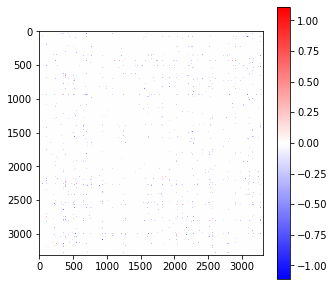

In [60]:
def bwr_plot(arr,**kwargs):
    vmax = np.max(np.abs(arr))
    plt.imshow(arr,vmax=vmax,vmin=-vmax,cmap='bwr')
plt.figure(figsize=(5,5))
bwr_plot(gi_csc.toarray());plt.colorbar()

Text(0.5, 0, 'score')

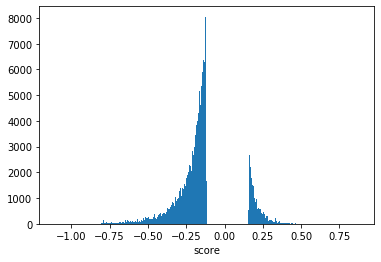

In [64]:
plt.hist(gint['score'],bins = int(np.sqrt(len(gint))));
plt.xlabel('score')

# compute PI network properties

In [11]:
import networkx as nx
pi_graph = nx.from_scipy_sparse_matrix(pi_csc,create_using=nx.Graph)

In [12]:
def dict_to_np(d,n): #ensures proper ordering, if for whatever reason the keys are out of numerical order
    return np.array([d[i] for i in range(len(d))])

## centrality measures

### closeness

In [272]:
closeness_dict = dict_to_np(nx.closeness_centrality(pi_graph))

In [13]:
#closeness = np.load('closeness-arr-032720.npy')

In [284]:
#np.save('closeness-arr-03272fff0.npy',closeness_arr)

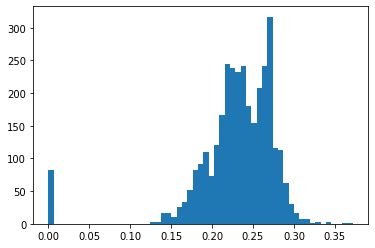

In [327]:
plt.hist(closeness,bins = int(np.sqrt(n_genes)));

### degree

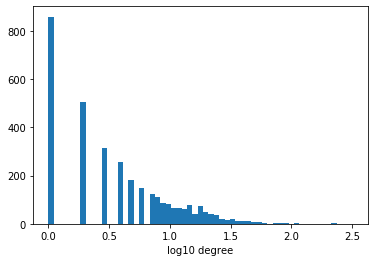

In [14]:
degree = np.array(pi_csc.sum(axis=1)).ravel()
plt.hist(np.log10(degree),bins = int(np.sqrt(n_genes)));
plt.xlabel('log10 degree')
plt.show()

### eigenvector centrality

find the perron-frobenius eigenvector

84 are zero


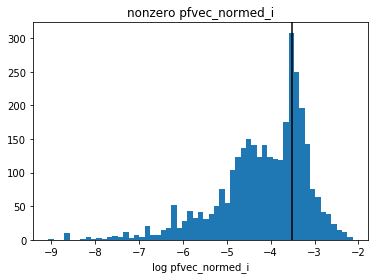

In [15]:
eigs, vecs = slin.eigsh(pi_csc.astype(np.float),k=1)
pfeig, pfvec = eigs[0], vecs[:,0]
#clean up pfvec
pfvec[np.isclose(pfvec,0)] = 0

pfvec = pfvec/np.sign(pfvec.sum())
assert(not np.any(pfvec < 0)) #assert non-negativity of pfvec
print(np.count_nonzero(np.isclose(pfvec,0)),'are zero')

pfvec_normed = pfvec/np.sum(pfvec)
plt.hist(np.log10(pfvec_normed[pfvec>0]),bins=int(np.sqrt(n_genes)));
plt.axvline(np.log10(1/n_genes),c='black')
plt.title('nonzero pfvec_normed_i')
plt.xlabel('log pfvec_normed_i')
plt.show()

### Betweenness centrality

In [328]:
betweenness_dict = nx.betweenness_centrality(pi_graph)
betweenness = dict_to_np(betweenness_dict)

In [17]:
#betweenness = np.load('betweenness-032720.npy')

In [332]:
#np.save('betweenness-032720fff.npy',betweenness)

## protein pair metrics

### Shortest paths

In [357]:
%%time
shortest_iter = nx.shortest_path_length(pi_graph)
shortest_mat_lt = np.full([n_genes,n_genes],0)
for source, targets in shortest_iter:
    for target, dist in targets.items():
        if target < source:
            shortest_mat_lt[source,target] = dist
shortest_mat = shortest_mat_lt + shortest_mat_lt.T #symmetrize

CPU times: user 1min 42s, sys: 4 ms, total: 1min 42s
Wall time: 1min 42s


In [37]:
#consider storing a sparse csc upper triangular matrix
#stores dense matrix 
if np.max(shortest_mat) <= 255:
    np.save('cached/yeast/032720/shortestu8.npy',shortest_mat.astype(np.uint8))
    print('saved')

saved


In [19]:
#shortest_mat_lt = np.load('shortest_mat_lt-032730.npy')

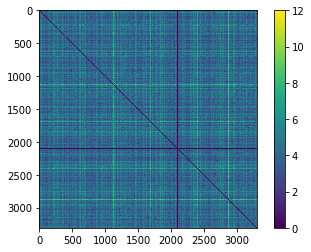

/home/akuczala/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


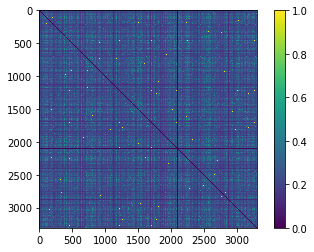

In [20]:

plt.imshow(shortest_mat); plt.colorbar(); plt.show()
inv_dist_mat = 1./shortest_mat
inv_dist_mat[shortest_mat == 0] = 0
plt.imshow(inv_dist_mat); plt.colorbar(); plt.show()

### Common neighbors

In [426]:
%%time
def n_neighbors(pi_graph,i,j):
    return len(list(nx.common_neighbors(pi_graph,i,j)))
neighbor_pairs, ilist, jlist = list(zip(*[
    (n_neighbors(pi_graph,i,j),i,j)
    for i,j in itertools.product(range(n_genes),range(n_genes))
    if i < j]))
#create symmetric matrix
neighbor_mat_csc = sparse.csc_matrix(sparse.coo_matrix(
        (neighbor_pairs + neighbor_pairs,(ilist + jlist,jlist + ilist))
))

CPU times: user 1min 18s, sys: 616 ms, total: 1min 19s
Wall time: 1min 19s


In [438]:
#sparse.save_npz('neighbors-03272fff0.npz',neighbor_mat_coo)

In [21]:
neighbor_mat_csc=sparse.load_npz('neighbors-032720.npz')

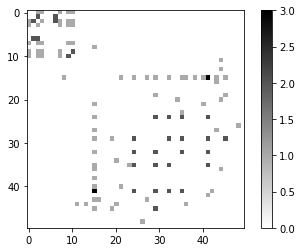

In [22]:
plt.imshow(neighbor_mat_csc.toarray()[:50,:50],cmap='gray_r'); plt.colorbar()

# make samples, labels

Paladugu excludes proteins localized to mitochondria

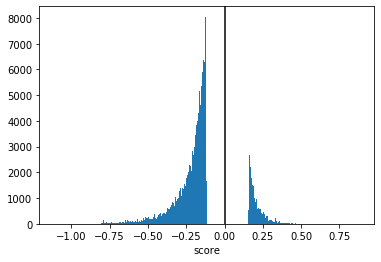

left 147798
right 25671


In [23]:
class_sign = -1
label_thresh = 0
plt.hist(gint['score'],bins = int(np.sqrt(len(gint))));
plt.axvline(label_thresh,c='black')
plt.xlabel('score'); plt.show()
print("left", np.count_nonzero(gint['score']<label_thresh))
print("right", np.count_nonzero(gint['score']>label_thresh))


In [24]:
ab_names = ['a','b']
vertex_features = 'deg,eigcent,closeness,betweenness'.split(',')
vertex_data = [degree,pfvec_normed,closeness,betweenness]
pair_features = 'invdist,comneigh'.split(',')
pair_data = [inv_dist_mat,neighbor_mat_csc.toarray()] #seems like i shouldn't need to turn into a np array here
features = list(itertools.product(ab_names,vertex_features)) + list(itertools.product(['pair'],pair_features))
samples = gint.copy()

samples['label'] = samples['score']*class_sign>label_thresh*class_sign

#map vertex features to samples
for vfeat, vdat in zip(vertex_features,vertex_data):
    samples['a',vfeat] = vdat[samples.a.i]
    samples['b',vfeat] = vdat[samples.b.i]
#vertex pair features
for pfeat, pmat in zip(pair_features,pair_data):
    samples['pair',pfeat] = pmat[samples.a.i,samples.b.i]
    
#take subset with equal number of positive and negative scores

neg_samples = samples[samples['score'] < -0.5].sample(frac=0.9)
assert len(neg_samples) < len(samples[samples.score > 0]), 'Not enough positive scores'
pos_samples = samples[samples['score'] > 0].sample(n = len(neg_samples))
#join positive and negative samples, and randomize
small_samples = neg_samples.append(pos_samples,verify_integrity = True).sample(frac=1)
n_small_samples = len(small_samples)

#divide into training, testing
frac_test = 0.2
n_test = int(n_small_samples*frac_test)
n_train = n_small_samples - n_test

small_training = small_samples.iloc[:n_train]
small_testing = small_samples.iloc[n_train:]
#display(samples)
#display(small_samples)
print('number of small samples:',n_small_samples)
print('number of samples:',len(samples))

number of small samples: 10154
number of samples: 173469


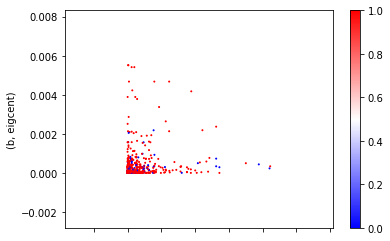

In [466]:
plot_sample = samples.sample(n=500)
plot_sample.plot.scatter(x=('a','eigcent'),y=('b','eigcent'),
                         c = plot_sample['label'],cmap='bwr',s=1)
plt.show()

# fit data

## imports

In [31]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import sklearn.metrics as metrics
from sklearn.inspection import permutation_importance

## functions

In [26]:
def train(model,train_samples,features):
    model.fit(train_samples[features],train_samples['label'])

def predict(model,test_samples,features):
    model.predict(test_samples[features])

def cross_validate(model,samples,features):
    scores = cross_val_score(model, samples[features], samples['label'], cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores

def calc_matt_coef(model,test_samples,features):
    return metrics.matthews_corrcoef(test_samples['label'],model.predict(test_samples[features]))

def plot_pr_curve(model,test_samples,features,ax = None):
    if ax is None:
        ax = plt.gca()
    metrics.plot_precision_recall_curve(model,test_samples[features],test_samples['label'],ax = ax)
    
def plot_roc_curve(model,test_samples,features,ax=None):
    if ax is None:
        ax = plt.gca()
    metrics.plot_roc_curve(model,test_samples[features],test_samples['label'],ax =ax)
    ax.plot([0,1],[0,1],c='gray',linestyle='--')
    ax.set_aspect(1)
    
def plot_confusion_matrix(model,samples,features,ax=None):
    if ax is None:
        ax = plt.gca()
    return metrics.plot_confusion_matrix(model,samples[features],samples['label'],ax = ax)

In [27]:
def calc_importance(model,samples,features):
    importance_dict = permutation_importance(
        model,samples[features],samples['label'])
    return importance_dict

def plot_importances(features,importances,axes = None):
    if axes is None:
        fig, axes = plt.subplots(1,2,figsize=(18,6))
    
    #convert importance matrix to dataframe
    imdf = pd.DataFrame(importances['importances'].T,
                        columns = pd.MultiIndex.from_tuples(features))
    #combine features from a, b
    imdf_ab = imdf.stack(level=0)
    
    #compute importance statistics
    imdf_stats = \
         imdf \
        .agg([np.mean,np.std]) \
        .transpose() \
        .sort_values('mean',axis=0,ascending=False)
    #display(imdf_stats)

    #errorbar plot of feature importance
    imdf_stats.plot(y='mean',ax=axes[0])
    axes[0].errorbar(np.arange(len(imdf_stats)),imdf_stats['mean'],
                 yerr=imdf_stats['std'],linestyle='',capsize=10,marker='o')
    axes[0].set_ylabel('importance')
    
    #box plot of feature importance
    imdf_ab.reindex(imdf_ab.mean().sort_values(ascending=False).index, axis=1).boxplot(ax=axes[1])

## Benchmarking

## Logistic

Accuracy: 0.65 (+/- 0.01)


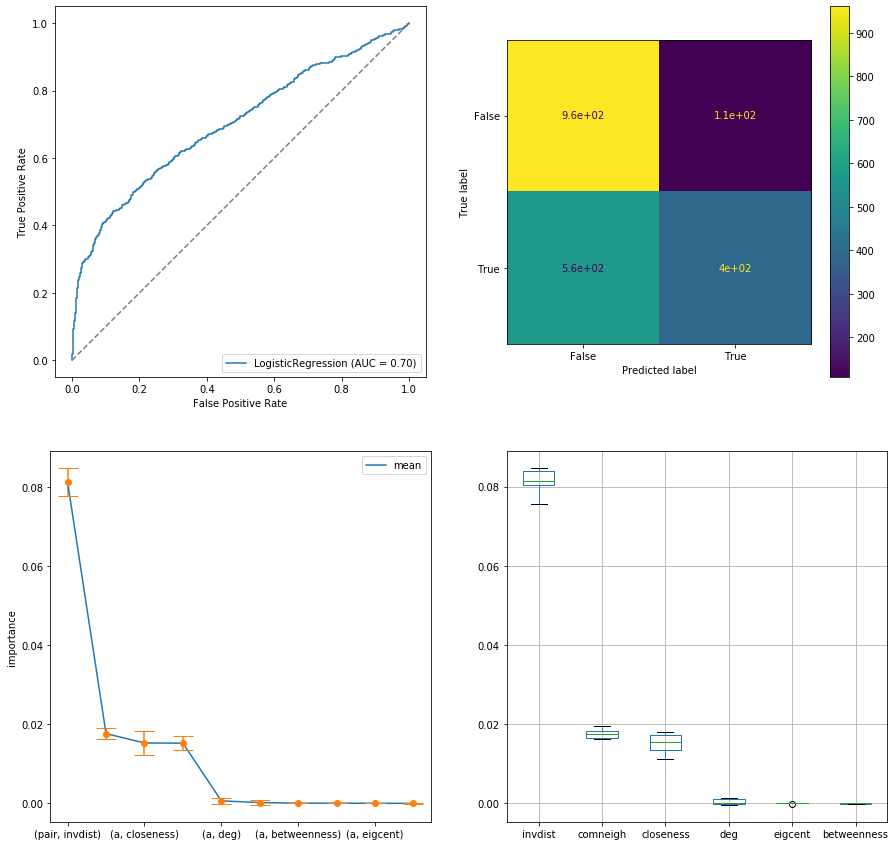

## Random Forest

Accuracy: 0.72 (+/- 0.02)


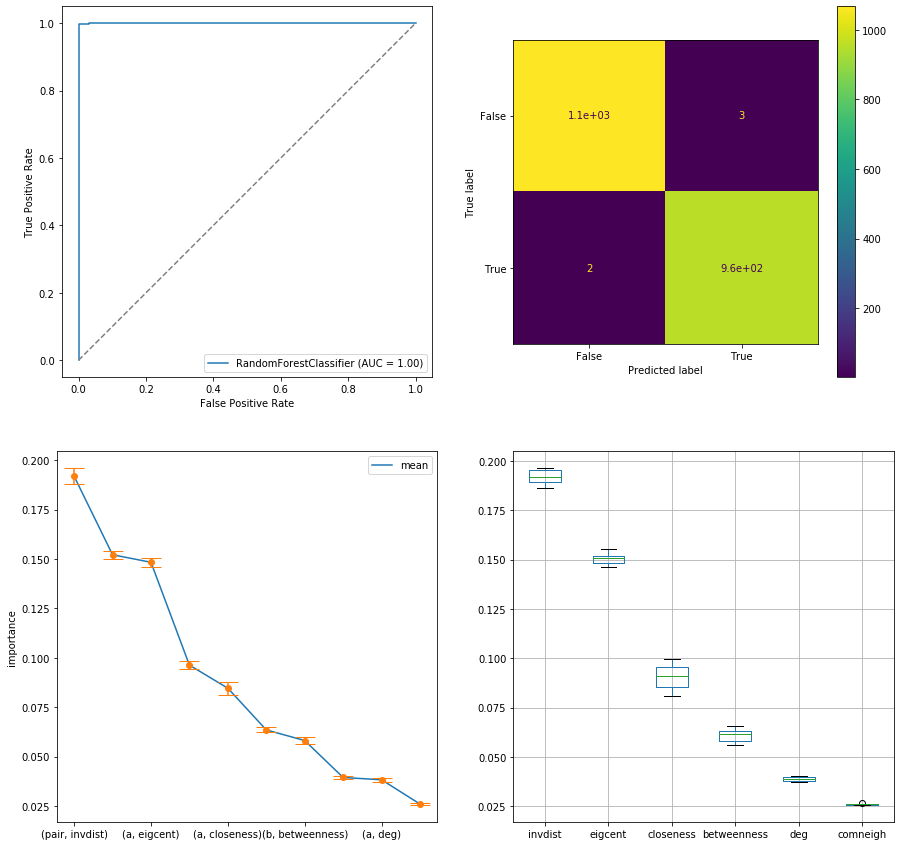

## SVM

Accuracy: 0.61 (+/- 0.01)


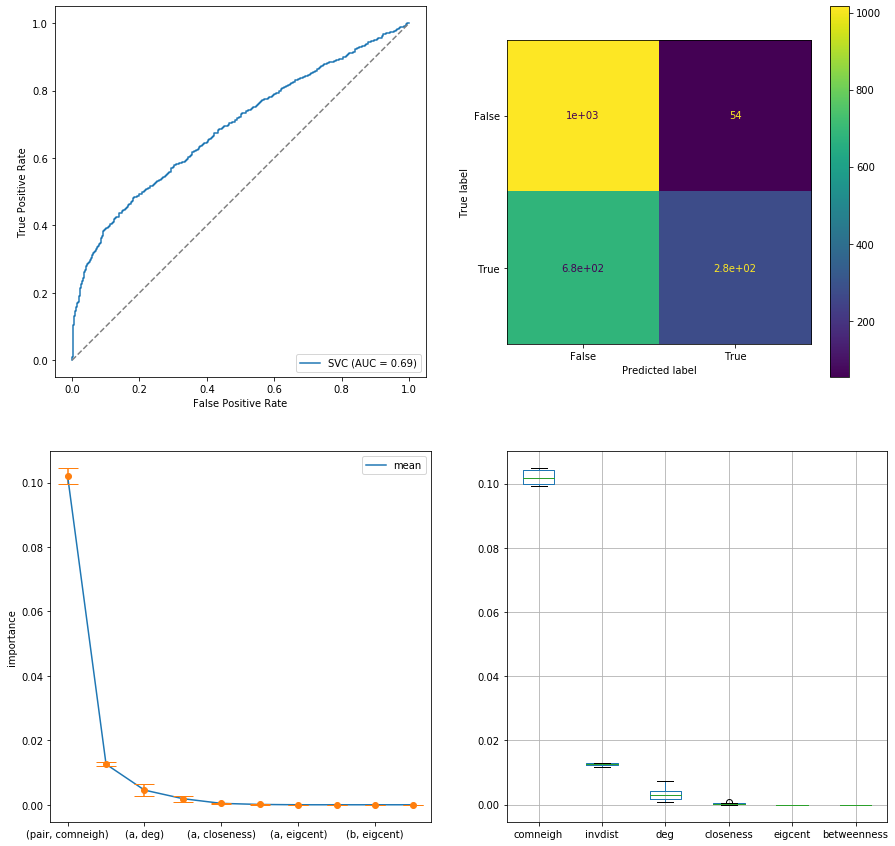

In [32]:
models = [LogisticRegression(max_iter=500),RandomForestClassifier(),SVC()]
model_names = ['Logistic','Random Forest','SVM']
for model, model_name in list(zip(models,model_names)):
    display_markdown(Markdown('## ' + model_name))
    cross_validate(model,small_samples,features)
    train(model,small_samples,features)
    test_results = predict(model,small_testing,features)
    
    fig, axes = plt.subplots(2,2,figsize=(15,15))
    plot_roc_curve(model,small_testing,features,ax = axes[0,0])
    plot_confusion_matrix(model,small_testing,features,ax = axes[0,1])
    plot_importances(features,calc_importance(model,small_samples,features),axes=axes[1])
    plt.show()

# misc/old

In [220]:
results = pd.DataFrame()
true_results = small_testing['label']
results['correct'] = small_testing['label'] == test_results
results['TP'] = correct & test_results
results['TN'] = correct & ~test_results
results['FP'] = ~correct & test_results
results['FN'] = ~correct & ~test_results
#n_correct, n_true_pos, n_true_neg = map(np.count_nonzero,[correct,true_pos,true_neg])
results_summary = pd.DataFrame(columns=['n','f'])
for row in 'correct,TP,TN,FP,FN'.split(','):
    results_summary.loc[row,'n'] = np.count_nonzero(results[row])
    results_summary.loc[row,'f'] = results_summary.loc[row,'n']/len(small_testing)
#f_correct, f_true_pos, f_true_neg = map(lambda x: x/len(small_testing),[n_correct,n_true_pos,n_true_neg])
results_summary

,n,f
correct,9642,0.555831
TP,16966,0.978037
TN,15635,0.901309
FP,16011,0.922984
FN,15634,0.901251


f1 score or matthew's correlation coef

## counting things

In [185]:
gi_sparse.shape

(3307, 3307)

In [186]:
pi_sparse.shape

(3306, 3307)

In [152]:
costanzo_genes = list(set(costanzo_unique['a'].append(costanzo_unique['b'])))

In [153]:
len(costanzo_genes)

5293

In [154]:
len(costanzo_genes)

5293

In [155]:
len(gene_names)

3307

In [156]:
len(set(costanzo_genes + gene_names))

5646

In [148]:
3885 + 3307 - 5061

2131

In [157]:
5293 + 3307 - 5646

2954

In [158]:
326790/(6000**2)

0.0090775